# Onside Kick Research

## 1. Load the data 

In [274]:
import json
import re
from os.path import join
import os
import unicodedata

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, auc
import shap

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412710,2013,1,regular,True,False,3746.0,2013-08-29 23:00:00+00:00,2710,Western Illinois,MVFC,fcs,42.0,NaN,2261,Hampton,MEAC,fcs,9.0,NaN
4,332412050,2013,1,regular,True,False,3919.0,2013-08-29 23:00:00+00:00,2050,Ball State,Mid-American,fbs,51.0,NaN,2287,Illinois State,MVFC,fcs,28.0,NaN


In [5]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [421]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)

        tmp["start_time_minutes"] = tmp["start_time"].apply(lambda x: x["minutes"])
        tmp["start_time_seconds"] = tmp["start_time"].apply(lambda x: x["seconds"])
        tmp["end_time_minutes"] = tmp["end_time"].apply(lambda x: x["minutes"])
        tmp["end_time_seconds"] = tmp["end_time"].apply(lambda x: x["seconds"])
        tmp.drop(columns=["start_time","end_time"], inplace=True)

        season_drives = tmp.copy()
                
        season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(season_drives)
    
drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
drives.head()

Reading ../data/drives/2013.parquet from cached data
Reading ../data/drives/2014.parquet from cached data
Reading ../data/drives/2015.parquet from cached data
Reading ../data/drives/2016.parquet from cached data
Reading ../data/drives/2017.parquet from cached data
Reading ../data/drives/2018.parquet from cached data
Reading ../data/drives/2019.parquet from cached data
Reading ../data/drives/2020.parquet from cached data
Reading ../data/drives/2021.parquet from cached data
Reading ../data/drives/2022.parquet from cached data
Reading ../data/drives/2023.parquet from cached data
Reading ../data/drives/2024.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000601,1,False,1,25,75,1,36,64,6,11,PUNT,True,0,0,0,0,15,0,11,55
1,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000602,2,True,1,77,77,1,16,16,12,61,FG GOOD,False,0,0,3,0,11,55,5,52
2,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000603,3,False,1,48,52,1,76,24,9,28,FG MISSED,True,0,3,0,3,5,52,2,21
3,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000604,4,True,1,76,76,1,0,0,3,76,RUSHING TD,False,3,0,10,0,2,21,1,16
4,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000605,5,False,1,25,75,2,45,55,5,20,PUNT,True,0,10,0,10,1,16,14,53


In [6]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    venues = pd.DataFrame([val.to_dict() for val in data])
    venues.columns = convert_to_snake_case(venues.columns)
    venues.to_parquet(file_path)

venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [7]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [8]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


## 2. Predict Kickoff Decision: Onside or Regular

In [328]:
def remove_accents(text):
    if not isinstance(text, str):
        return text
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)
    )

kickoff_plays_types = ["Kickoff", "Kickoff Return (Offense)", "Kickoff Return Touchdown"]

kickoff_plays = (
    plays
    .query('play_text.notnull()')
    .query('play_type in @kickoff_plays_types or play_text.str.lower().str.contains("on-side")')
    .assign(
        onside_kick=lambda x: x['play_text'].str.lower().str.contains('on-side')
    )
    .assign(
        recovery_team=lambda x: np.where(
            x.onside_kick,
            np.where(x.play_text.str.extract(r'on-side kick recovered by (.*?) at the')[0].notnull(),
                x.play_text.str.extract(r'on-side kick recovered by (.*?) at the')[0],
                x.play_text.str.extract(r'on-side kick, recovered by (.*?) on')[0]
            ),
            np.nan
        ),
        offense_normalized=lambda x: x['offense'].str.lower().apply(remove_accents)
            .str.replace(r'ualbany', 'albany', regex=True)
            .str.replace(r'\b st \b', ' state', regex=True)
            .str.replace(r'\b st$', ' state', regex=True)
            .str.replace(r'^st \b', 'state ', regex=True)
            .str.replace(r'\b\'\b', '', regex=True)
            .str.replace(r'[()]', '', regex=True),
        defense_normalized=lambda x: x['defense'].str.lower().apply(remove_accents)
            .str.replace(r'ualbany', 'albany', regex=True)
            .str.replace(r'\b st \b', ' state', regex=True)
            .str.replace(r'\b st$', ' state', regex=True)
            .str.replace(r'^st \b', 'state ', regex=True)
            .str.replace(r'\b\'\b', '', regex=True)
            .str.replace(r'[()]', '', regex=True)
    )
    .assign(
        recovery_team=lambda x: x.recovery_team.str.lower().apply(remove_accents)
            .str.replace(r'[()]', '', regex=True)
            .str.replace(r'\b st \b', ' state', regex=True)
            .str.replace(r'\b st$', ' state', regex=True)
            .str.replace(r'\b eastrn \b', ' eastern ', regex=True)
            .str.replace(r'^eastrn \b', 'eastern ', regex=True)
            .str.replace(r'\b eastrn$', ' eastern', regex=True)
            .str.replace(r'\b westrn \b', ' western ', regex=True)
            .str.replace(r'^westrn \b', 'western ', regex=True)
            .str.replace(r'\b westrn$', ' western', regex=True)
            .str.replace(r'\b southrn \b', ' southern ', regex=True)
            .str.replace(r'^southrn \b', 'southern ', regex=True)
            .str.replace(r'\b southrn$', ' southern', regex=True)
            .str.replace(r'\b northrn \b', ' northern ', regex=True)
            .str.replace(r'^northrn \b', 'northern ', regex=True)
            .str.replace(r'\b northrn$', ' northern', regex=True)
            .str.replace(r'\b north \b', ' northern ', regex=True)
            .str.replace(r'ul lafayette', 'louisiana', regex=True)
            .str.replace(r'^ga \b', 'georgia ', regex=True)
            .str.replace(r'\b fl$', '', regex=True)
            .str.replace(r'olddominion', 'old dominion', regex=False)
            .str.replace(r'texassan', 'utsa', regex=False)
            .str.replace(r'\b tenn$', ' tennessee', regex=True)
            .str.replace(r'jmu', 'james madison', regex=False)
            .str.replace(r'appalachian state', 'app state', regex=False)
            .str.replace(r'northernil', 'northern illinois', regex=False)
            .str.replace(r'connecticut', 'uconn', regex=False)
            .str.replace(r'\b intl$', ' international', regex=True)
            .str.replace(r'^abil \b', 'abilene ', regex=True)
            .str.replace(r'eku', 'eastern kentucky', regex=False)
            .str.replace(r'^fla \b', 'florida ', regex=True)
            .str.replace(r'\b mich$', ' michigan', regex=True)
            .str.replace(r'ut san antonio', 'utsa', regex=False)
            .str.replace(r'niu team', 'northern illinois', regex=False)
            .str.replace(r'nc a&t', 'north carolina a&t', regex=False)
            .str.replace(r'coastl carolina', 'coastal carolina', regex=False)
            .str.replace(r'cmu team', 'central michigan', regex=False)
            .str.replace(r'tenn martin', 'ut martin', regex=False)
            .str.replace(r'sam houston state', 'sam houston', regex=False)
            .str.replace(r'^gs \b', 'georgia southern ', regex=True)
            .str.replace(r'^cal davis\b', 'california davis', regex=True)
            .str.replace(r'^asu \b', 'arkansas state ', regex=True)
            .str.replace(r'^nc ratliff\b', 'north carolina', regex=True)
            .str.replace(r'^umass \b', 'massachusetts ', regex=True)
            .str.replace(r'north cent col', 'north central college', regex=False)
            .str.replace(r'^valpo \b', 'valparaiso ', regex=True)
            .str.replace(r'^utm \b', 'ut martin ', regex=True)
            .str.replace(r'sfa', 'stephen f. austin', regex=False)
            .str.replace(r'gasouthern', 'georgia southern', regex=False)
            .str.replace(r'incarnatew', 'incarnate word', regex=False)
            .str.replace(r'nc central', 'north carolina central', regex=False)
            .str.replace(r'^ks \b', 'kansas state ', regex=True)
            .str.replace(r'^tln \b', 'tulane ', regex=True)
            .str.replace(r'central ark', 'central arkansas', regex=False)
            .str.replace(r'^miz \b', 'missouri ', regex=True)
            .str.replace(r'arizonast', 'arizona state', regex=False)
            .str.strip()
    )
    .assign(
        recovered_by=lambda x: np.where(
            x.onside_kick & x.recovery_team.notnull(),
            np.where(
                x.recovery_team == x.offense_normalized,
                'offense',
                np.where(
                    x.recovery_team == x.defense_normalized,
                    'defense',
                    np.where(
                        [rt.startswith(on) if pd.notnull(rt) and pd.notnull(on) else False
                        for rt, on in zip(x.recovery_team, x.offense_normalized)],
                        'offense',
                        np.where(
                            [rt.startswith(dn) if pd.notnull(rt) and pd.notnull(dn) else False
                            for rt, dn in zip(x.recovery_team, x.defense_normalized)],
                            'defense',
                            'unknown'
                        )
                    )
                )
            ),
            np.where(
                x.onside_kick,
                np.where(
                    x.play_text.str.lower().str.contains(' return ', regex=False),
                    'defense',
                    'unknown'
                ),
                None
            )
        )
    )
    .query('recovered_by != "unknown"')
    .drop(columns=['recovery_team', 'offense_normalized', 'defense_normalized'])
    .assign(
        score_diff = lambda x: x['offense_score'] - x['defense_score'],
        pct_game_played = lambda x: (((x['period'] - 1) * 15 * 60) + ((15 * 60) - 
                                      (x['clock_minutes'] * 60 + x['clock_seconds']))) / (4 * 15 * 60),
        seconds_remaining = lambda x: (x['period'] - 1) * 15 * 60 + (15 * 60) - 
                                      (x['clock_minutes'] * 60 + x['clock_seconds']),
    )
    .assign(
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['seconds_remaining']) / 3600),
        need_onside_kick = lambda x: np.where(
            # Losing with =< 60 seconds
            ((x.score_diff < 0) & (x.seconds_remaining <= 60)) |
            # Losing with <= 2 min and <= 1 timeout
            ((x.score_diff < 0) & (x.seconds_remaining <= 120) & (x.offense_timeouts <= 1)) |
            # Losing by 2+ possessions with <= 3 min
            ((x.score_diff < -8) & (x.seconds_remaining <= 180)) |
            # Down 3+ scores (17+) with < 5 min
            ((x.score_diff <= -17) & (x.seconds_remaining < 300)),
            True, False
        ),
        losing_by_a_score_under_one_minute= lambda x: np.where(
            (x.seconds_remaining < 60) & (-8 <= x.score_diff) & (x.score_diff < 0) & (x.offense_timeouts <= 2),
            True, False
        ),
        losing_by_a_score_under_two_minutes = lambda x: np.where(
            (x.seconds_remaining < 120) & (-8 <= x.score_diff) & (x.score_diff < 0) & (x.offense_timeouts <= 1),
            True, False
        ),
        losing_by_two_scores_under_three_minutes = lambda x: np.where(
            (x.seconds_remaining < 180) & (-17 <= x.score_diff) & (x.score_diff < -8),
            True, False
        ),
        losing_by_three_scores_under_five_minutes = lambda x: np.where(
            (x.seconds_remaining < 300) & (x.score_diff <= -17),
            True, False
        )
    )
)

In [329]:
kickoff_plays.onside_kick.value_counts(normalize=True)

onside_kick
False    0.988169
True     0.011831
Name: proportion, dtype: float64

In [349]:
features = [
    'score_diff', 
    'pct_game_played',
    'diff_time_ratio',
    'offense_timeouts',
]

data = kickoff_plays[features + ['onside_kick']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['onside_kick']
)
test_x, test_y = test_data[features], test_data['onside_kick']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[features], 
    train_data['onside_kick'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['onside_kick']
)

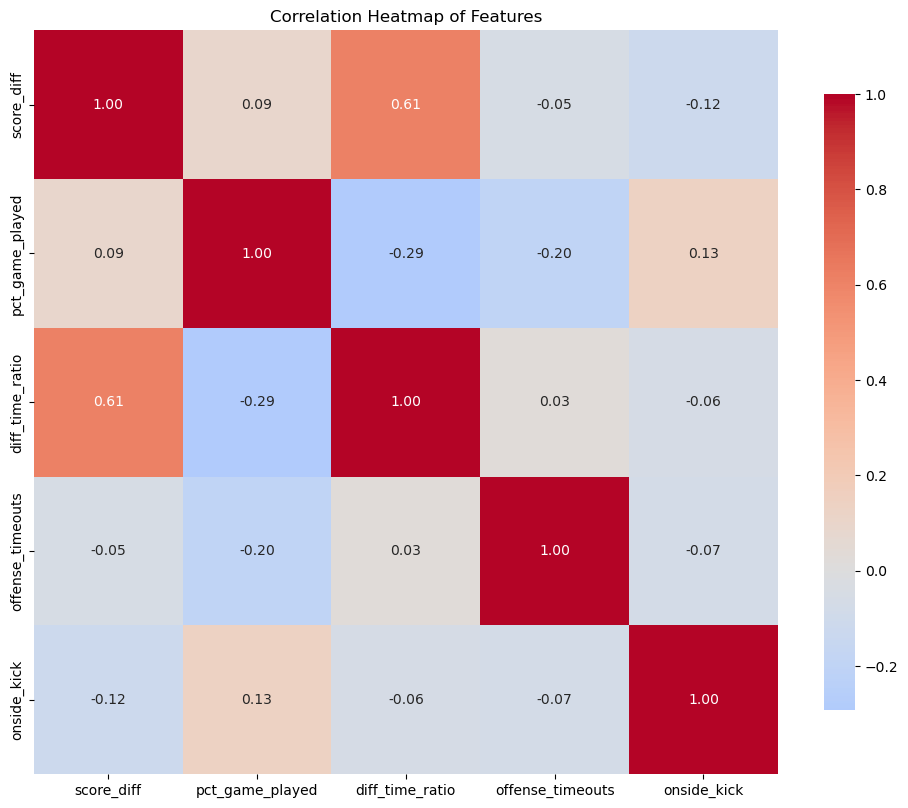

In [350]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [352]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

feature_names = [
    'score_diff', 
    'pct_game_played',
    'diff_time_ratio',
    'offense_timeouts',
]

monotonic_constraints_map = {
    "offense_timeouts": -1
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "monotone_constraints": monotonic_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="onside_kick_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    # 'interaction_constraints': interaction_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

# Evaluate on train set
train_preds = final_model.predict(dtrain)
print(f"Final train log loss: {log_loss(train_y, train_preds):0.3f}")
precision, recall, _ = precision_recall_curve(train_y, train_preds)
pr_auc = auc(recall, precision)
print(f"Final train PR AUC: {pr_auc:0.3f}")

# Evaluate on validation set
valid_preds = final_model.predict(dvalid)
print(f"Final validation log loss: {log_loss(valid_y, valid_preds):0.3f}")
precision, recall, _ = precision_recall_curve(valid_y, valid_preds)
pr_auc = auc(recall, precision)
print(f"Final validation PR AUC: {pr_auc:0.3f}")

# Evaluate on test set
dtest = xgb.DMatrix(test_x, label= test_y)
test_preds = final_model.predict(dtest)
print(f"Final test log loss: {log_loss(test_y, test_preds):0.3f}")
precision, recall, _ = precision_recall_curve(test_y, test_preds)
pr_auc = auc(recall, precision)
print(f"Final test PR AUC: {pr_auc:0.3f}")

Number of boosted rounds: 115
Final train log loss: 0.037
Final train PR AUC: 0.393
Final validation log loss: 0.036
Final validation PR AUC: 0.390
Final test log loss: 0.037
Final test PR AUC: 0.416


In [353]:
p = kickoff_plays.onside_kick.value_counts(normalize=True).values[0]
baseline_log_loss = -(p * np.log(p) + (1 - p) * np.log(1 - p))
print(f"Baseline probability of kickoff attempt: {p:0.3f}")
print(f"Baseline log loss: {baseline_log_loss:0.3f}")

Baseline probability of kickoff attempt: 0.988
Baseline log loss: 0.064


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_77058/10610399.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


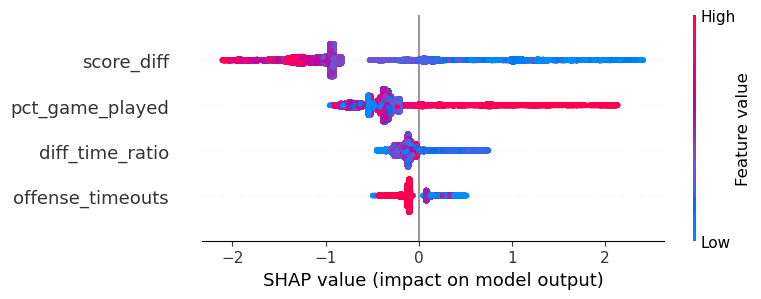

In [354]:
import shap
background = train_data[feature_names]
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, 
                 background, 
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

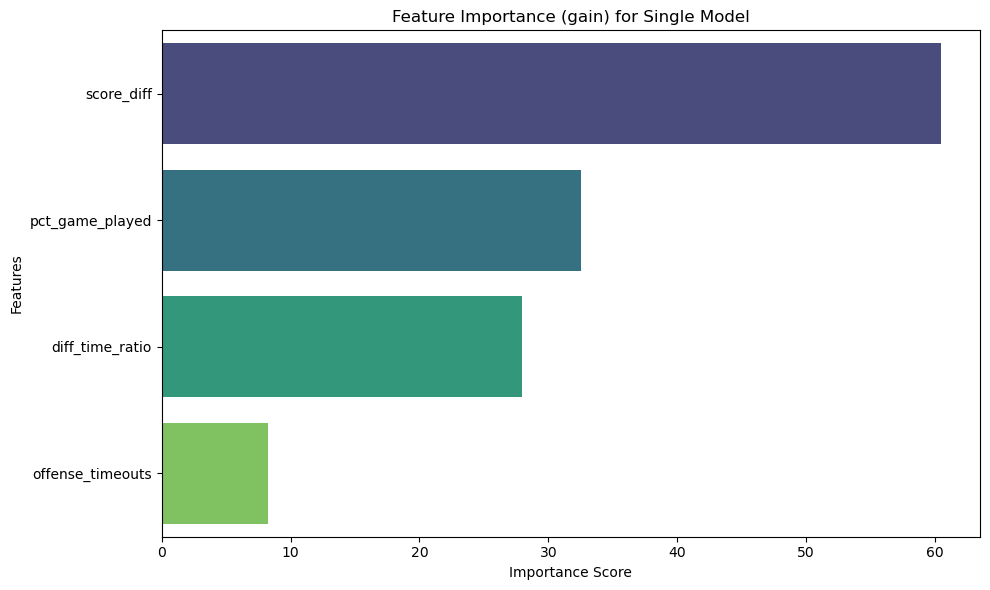

In [355]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [356]:
# predict onside_kick_proba for all plays
kickoff_plays['onside_kick_proba'] = final_model.predict(xgb.DMatrix(kickoff_plays[feature_names]))

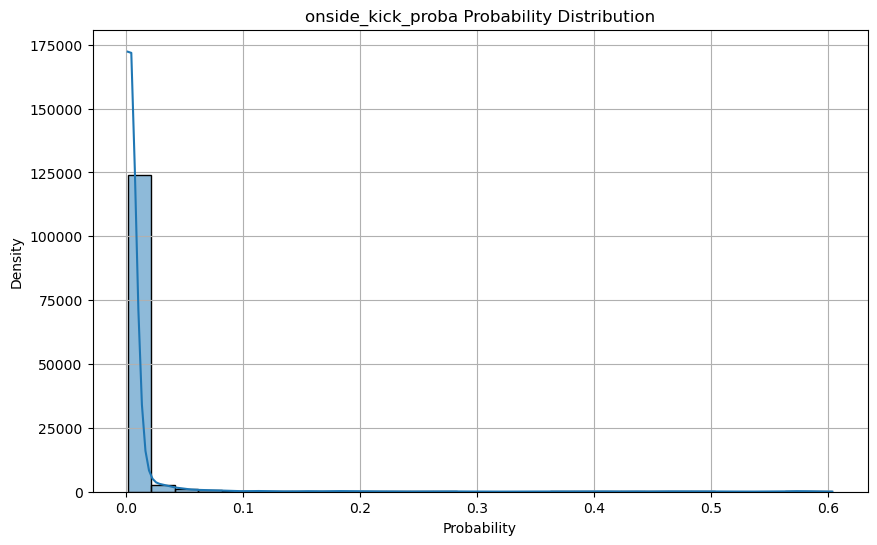

In [357]:
# plot win probability
def plot_wp(df, col):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(kickoff_plays, col='onside_kick_proba')

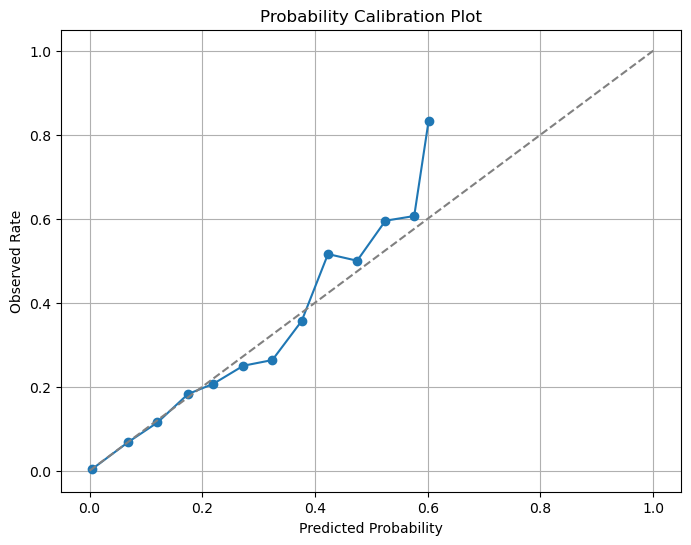

In [358]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(kickoff_plays, proba_col='onside_kick_proba', actual_col='onside_kick', bins=20)

In [360]:
kickoff_plays.sort_values(
    by='onside_kick_proba', 
    ascending=False
)[['offense','defense'] + feature_names + ['onside_kick', 'onside_kick_proba']].head(20)

,offense,defense,score_diff,pct_game_played,diff_time_ratio,offense_timeouts,onside_kick,onside_kick_proba
469926,NC State,North Carolina,-11,0.969444,-12.430057,0.0,True,0.603705
1563367,Texas Tech,TCU,-10,0.970556,-11.249941,0.0,True,0.603705
232728,Pittsburgh,Virginia,-5,0.975833,-5.507466,0.0,True,0.601086
760671,UTSA,UAB,-5,0.980278,-5.410420,0.0,True,0.601086
465023,Northern Illinois,Ohio,-5,0.970833,-5.618724,0.0,True,0.601086
242489,Georgia Tech,Duke,-6,0.975833,-6.608959,0.0,True,0.601086
1168284,UCLA,Colorado,-6,0.970833,-6.742469,0.0,True,0.601086
1368004,Kansas,West Virginia,-6,0.970833,-6.742469,0.0,False,0.601086
1162407,Boston College,Clemson,-6,0.978333,-6.543199,0.0,True,0.601086
1326926,Nebraska,Purdue,-5,0.972222,-5.587595,0.0,False,0.601086


In [361]:
model_dir = join('../models/raw', 'kickoffs')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, f"onside_decision_xgb.bin")
final_model.save_model(model_path)

print(f"Saved model to the '{model_dir}' folder.")

Saved model to the '../models/raw/kickoffs' folder.


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_77058/1082815795.py:6: UserWarning: [19:35:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  final_model.save_model(model_path)


## 3. Predict If Kicking Team Recovers Onside Kick
XGBoost Model preforms poorly -> onside kicks are two random (based on the available data) -> use base rates.

In [370]:
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'period', 'offense',
       'defense','recovered_by', 'clock_minutes', 'clock_seconds']

onside_kicks = (
    kickoff_plays.query('onside_kick == True')[cols].rename(
        columns={
            'id': 'play_id',
        }
    )
    .assign(
        kicking_team_recovered=lambda x: np.where(
            x['recovered_by'] == "offense", True, False
        ),
    )
    .drop(columns=['recovered_by'])
    .merge(
        weather[['id','temperature','wind_speed','precipitation','game_indoors']].rename(
            columns={'id': 'game_id'}
        ),
        on='game_id',
        how='left'
    )
    .merge(
        games[['id','season','week','venue_id']].rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'division', 'elo']].rename(columns={
            'team': 'offense', 
            'elo': 'offense_elo',
            'division': 'offense_division'
        }),
        on=['season', 'week', 'offense'],
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'division', 'elo']].rename(columns={
            'team': 'defense', 
            'elo': 'defense_elo',
            'division': 'defense_division'
        }),
        on=['season', 'week', 'defense'],
        how='left'
    )
    .merge(
        venues[['id', 'elevation']].rename(columns={'id': 'venue_id'}),
        on='venue_id',
        how='left'
    ).drop(columns=['venue_id'])
)

onside_kicks['elevation'] = onside_kicks['elevation'].astype(float)

onside_kicks = (
    onside_kicks
    .assign(
        pct_game_played = lambda x: (
            (((x['period'] - 1) * 15 * 60) +
             ((15 * 60) - (x['clock_minutes'] * 60 + x['clock_seconds']))) / (4 * 15 * 60)
        ),
        wind_speed = np.where(onside_kicks.game_indoors, 0, onside_kicks.wind_speed.fillna(int(onside_kicks.wind_speed.mean()))),
        elevation = onside_kicks.elevation.fillna(int(onside_kicks.elevation.astype(float).mean())),
        precipitation = np.where(onside_kicks.game_indoors, 0, onside_kicks.precipitation.fillna(int(onside_kicks.precipitation.mean()))),
        temperature = np.where(onside_kicks.game_indoors, 70, onside_kicks.temperature.fillna(int(onside_kicks.temperature.mean()))),
    )
    .drop(columns=['game_indoors'])
    .query('period.isin([1, 2, 3, 4]) and 0 <= pct_game_played <= 1') # No overtime attempts
)


onside_kicks.head()

,play_id,drive_id,game_id,drive_number,play_number,period,offense,defense,clock_minutes,clock_seconds,kicking_team_recovered,temperature,wind_speed,precipitation,season,week,offense_division,offense_elo,defense_division,defense_elo,elevation,pct_game_played
0,333622306200,33362230618,333622306,18,7,4,Michigan,Kansas State,1,15,False,61.0,7.0,0.0,2013,1,fbs,2687.727457,fbs,2878.346980,360.156952,0.979167
1,332422567305,33242256727,332422567,27,8,4,SMU,Texas Tech,1,5,True,100.9,4.7,0.0,2013,1,fbs,1995.644402,fbs,2322.587978,169.405808,0.981944
2,332430251149,33243025115,332430251,15,6,3,New Mexico State,Texas,15,0,False,98.1,7.0,0.0,2013,1,fbs,939.848251,fbs,2596.277134,160.308945,0.500000
3,332430249015,33243024901,332430249,1,3,1,Idaho,North Texas,13,0,True,100.9,3.4,0.0,2013,1,fbs,1088.241488,fbs,1248.586195,198.687195,0.033333
4,340010239263,34001023932,340010239,32,20,4,Baylor,UCF,1,15,False,70.0,0.0,0.0,2013,1,fbs,2625.137468,fbs,2171.347997,270.000000,0.979167


In [403]:
feature_names = [
    'temperature', 
    'wind_speed', 
    'precipitation',
    'offense_elo',
    'defense_elo', 
    'elevation', 
]

data = onside_kicks[feature_names + ['kicking_team_recovered']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['kicking_team_recovered']
)
test_x, test_y = test_data[feature_names], test_data['kicking_team_recovered']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data['kicking_team_recovered'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['kicking_team_recovered']
)

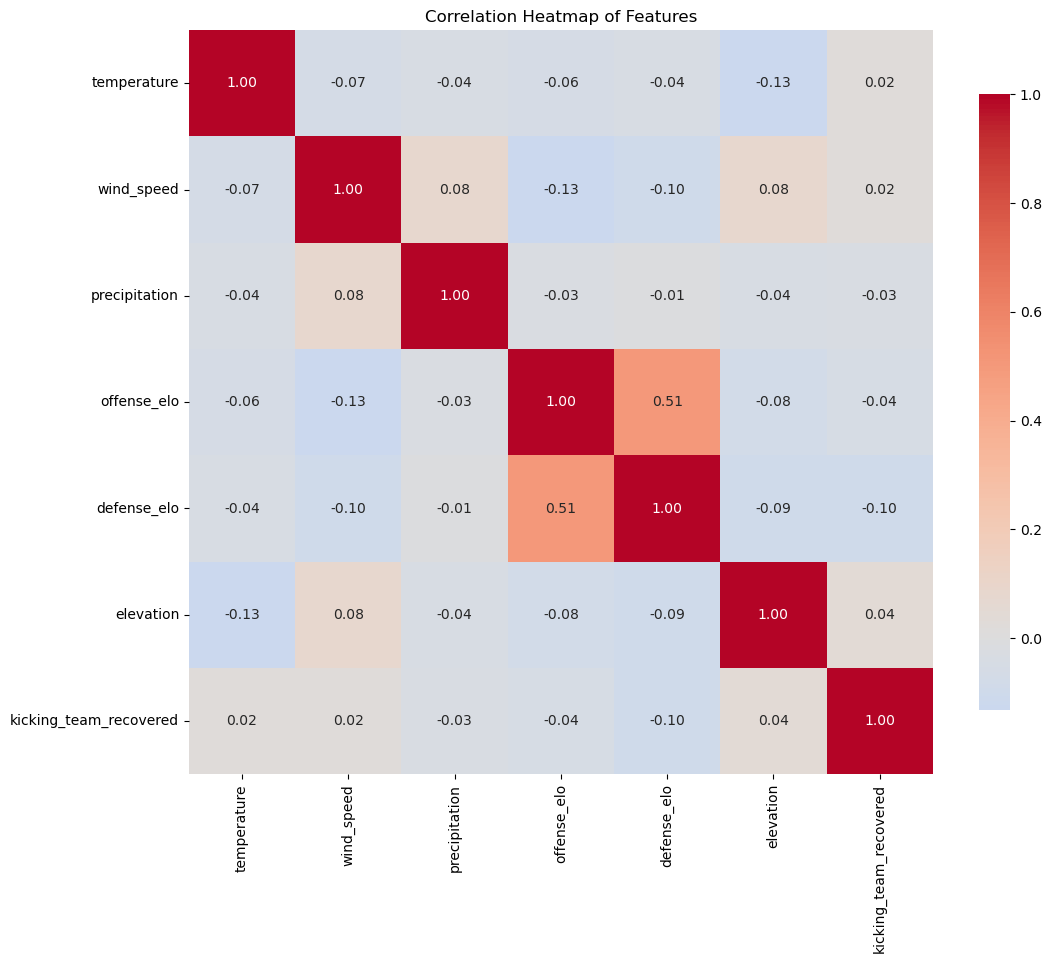

In [404]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [405]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="onside_kick_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    # 'interaction_constraints': interaction_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

# Evaluate on train set
train_preds = final_model.predict(dtrain)
print(f"Final train log loss: {log_loss(train_y, train_preds):0.3f}")
precision, recall, _ = precision_recall_curve(train_y, train_preds)
pr_auc = auc(recall, precision)
print(f"Final train PR AUC: {pr_auc:0.3f}")

# Evaluate on validation set
valid_preds = final_model.predict(dvalid)
print(f"Final validation log loss: {log_loss(valid_y, valid_preds):0.3f}")
precision, recall, _ = precision_recall_curve(valid_y, valid_preds)
pr_auc = auc(recall, precision)
print(f"Final validation PR AUC: {pr_auc:0.3f}")

# Evaluate on test set
dtest = xgb.DMatrix(test_x, label= test_y)
test_preds = final_model.predict(dtest)
print(f"Final test log loss: {log_loss(test_y, test_preds):0.3f}")
precision, recall, _ = precision_recall_curve(test_y, test_preds)
pr_auc = auc(recall, precision)
print(f"Final test PR AUC: {pr_auc:0.3f}")

Number of boosted rounds: 11
Final train log loss: 0.535
Final train PR AUC: 0.410
Final validation log loss: 0.551
Final validation PR AUC: 0.345
Final test log loss: 0.564
Final test PR AUC: 0.275


In [406]:
p = onside_kicks.kicking_team_recovered.value_counts(normalize=True).values[1]
baseline_log_loss = -(p * np.log(p) + (1 - p) * np.log(1 - p))
print(f"Baseline probability of onside kick recovery: {p:0.3f}")
print(f"Baseline log loss: {baseline_log_loss:0.3f}")

Baseline probability of onside kick recovery: 0.248
Baseline log loss: 0.560


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_77058/10610399.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


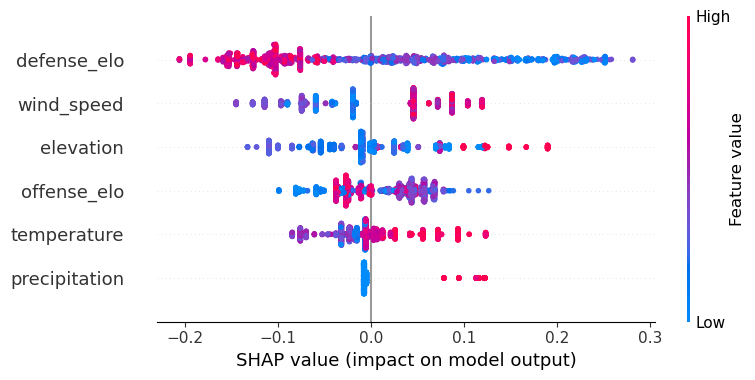

In [408]:
import shap
background = train_data[feature_names]
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, 
                 background, 
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

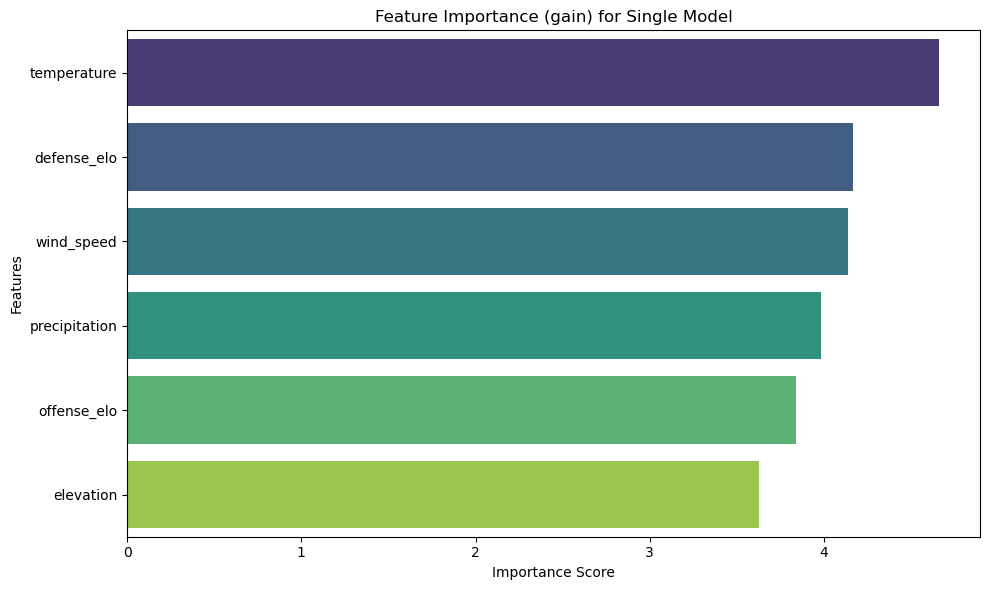

In [409]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [410]:
# predict onside_kick_proba for all plays
onside_kicks['onside_kick_recovery_proba'] = final_model.predict(xgb.DMatrix(onside_kicks[feature_names]))

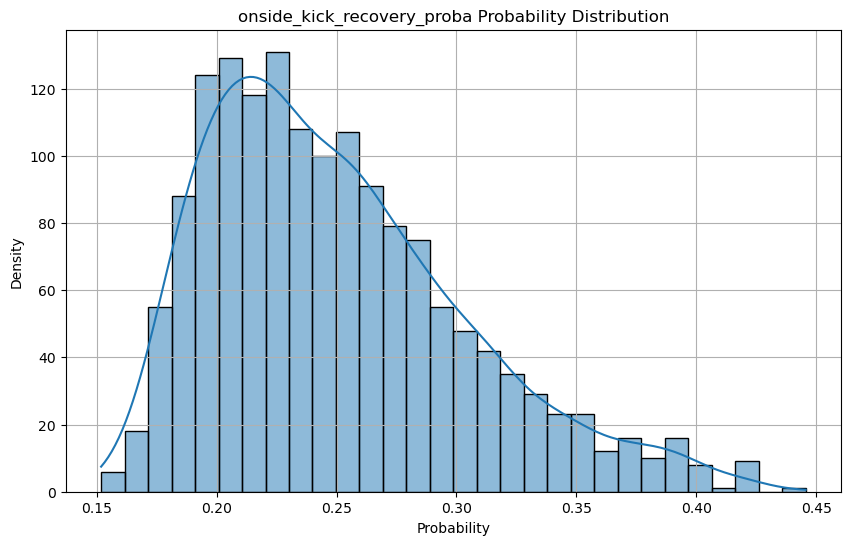

In [411]:
# plot win probability
def plot_wp(df, col):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(onside_kicks, col='onside_kick_recovery_proba')

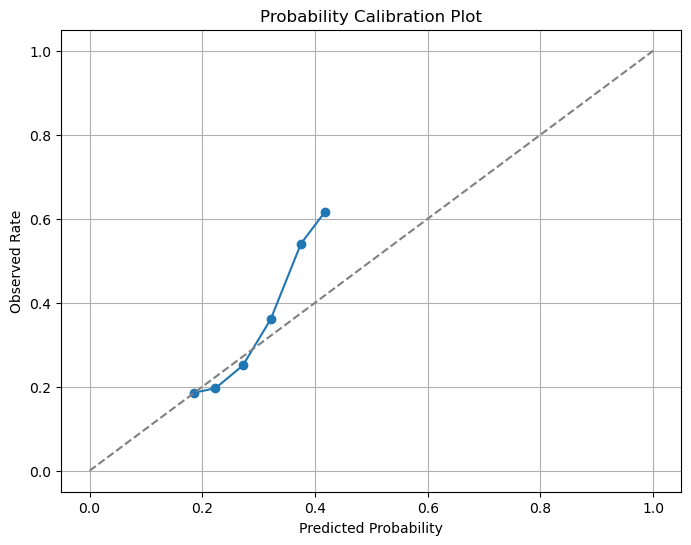

In [415]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(onside_kicks, proba_col='onside_kick_recovery_proba', actual_col='kicking_team_recovered', bins=20)

#### Using `0.247913` as the probability of recovering an onside kick, the empirical frequency from our dataset from 2013-2024.

In [374]:
onside_kicks.kicking_team_recovered.value_counts(normalize=True)

kicking_team_recovered
False    0.752087
True     0.247913
Name: proportion, dtype: float64

## 4. Predict the Yardline the Onside Kick is Recovered At
Did not attempt model to predict onside kick recovery yardline, too much randomness. Instead, opting to use the empricial distributions.

In [506]:
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'period', 'offense',
       'defense','recovered_by', 'clock_minutes', 'clock_seconds','play_text']

onside_kicks = (
    kickoff_plays.query('onside_kick == True')[cols].rename(
        columns={
            'id': 'play_id',
        }
    )
    .assign(
        pct_game_played = lambda x: (
            (((x['period'] - 1) * 15 * 60) +
             ((15 * 60) - (x['clock_minutes'] * 60 + x['clock_seconds']))) / (4 * 15 * 60)
        )
    )
    .query('period.isin([1, 2, 3, 4]) and 0 <= pct_game_played <= 1') # No overtime attempts
)


onside_kicks.head()

,play_id,drive_id,game_id,drive_number,play_number,period,offense,defense,recovered_by,clock_minutes,clock_seconds,play_text,pct_game_played
1569,333622306200,33362230618,333622306,18,7,4,Michigan,Kansas State,defense,1,15,Matt Wile on-side kick recovered by KANSAS ST ...,0.979167
2524,332422567305,33242256727,332422567,27,8,4,SMU,Texas Tech,offense,1,5,Chase Hover on-side kick recovered by SMU at t...,0.981944
2692,332430251149,33243025115,332430251,15,6,3,New Mexico State,Texas,defense,15,0,Maxwell Johnson on-side kick recovered by TEXA...,0.500000
2797,332430249015,33243024901,332430249,1,3,1,Idaho,North Texas,offense,13,0,Austin Rehkow on-side kick recovered by IDAHO ...,0.033333
3700,340010239263,34001023932,340010239,32,20,4,Baylor,UCF,defense,1,15,Aaron Jones on-side kick recovered by UCF at t...,0.979167


In [494]:
onside_kicks[['game_id','drive_number','recovered_by','play_text']].values[20:30]

array([[332430151, 20, 'defense',
        'Jarod Brown on-side kick recovered by EAST CAROLINA at the ECaro 45 out-of-bounds.'],
       [332502655, 31, 'defense',
        'Cairo Santos on-side kick recovered by SOUTH ALABAMA at the Tulan 44.'],
       [332500084, 15, 'defense',
        'Mitch Ewald on-side kick recovered by NAVY at the Ind 47.'],
       [332500084, 17, 'defense',
        'Mitch Ewald on-side kick recovered by NAVY at the Navy 42 out-of-bounds.'],
       [332502751, 30, 'defense',
        'Austin Rehkow on-side kick recovered by WYOMING at the Idaho 48.'],
       [332500153, 27, 'offense',
        'Josh Davis on-side kick recovered by MIDDLE TENN at the NCaro 48.'],
       [332500245, 18, 'defense',
        'Luc Swimberghe on-side kick recovered by TEXAS A&M at the SmHou 46.'],
       [332500068, 9, 'offense',
        'Dan Goodale on-side kick recovered by BOISE ST at the TnMar 43 N/A for 1 yard to the TnMar 43.'],
       [332500061, 2, 'offense',
        'Collin Barber

In [496]:
gid = 332502655
drive_number = 32
drives.query('game_id==@gid and drive_number==@drive_number')[['offense','start_yards_to_goal']]

,offense,start_yards_to_goal
3965,South Alabama,84


In [486]:
play_number = 1
plays.query('game_id==@gid and drive_number==@drive_number and play_number==@play_number')[['offense','yards_to_goal']]

,offense,yards_to_goal
9105,Fresno State,33


In [455]:
drives.query('game_id==@gid and drive_number==2')

,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
1417,Idaho,FBS Independents,North Texas,Conference USA,332430249,33243024902,2,False,1,9,9,1,40,40,3,5,PUNT,False,0,0,6,0,13,0,12,20


In [450]:
drive_number = 1
plays.query('game_id==@gid and drive_number==@drive_number').sort_values('play_number')[['offense','yards_to_goal', 'play_text','period', 'clock_minutes', 'clock_seconds']]

,offense,yards_to_goal,play_text,period,clock_minutes,clock_seconds
2798,Idaho,74,IDAHO penalty 5 yard false start on N/A accepted.,1,13,7
2796,Idaho,3,Austin Rehkow extra point BLOCKED.,1,13,0
2797,Idaho,65,Austin Rehkow on-side kick recovered by IDAHO ...,1,13,0


In [452]:
plays.query('game_id==@gid and drive_number.isin([1,2])').sort_values(['drive_number','play_number'])[['offense','yards_to_goal', 'play_text','drive_number','play_number','period', 'clock_minutes', 'clock_seconds']]

,offense,yards_to_goal,play_text,drive_number,play_number,period,clock_minutes,clock_seconds
2798,Idaho,74,IDAHO penalty 5 yard false start on N/A accepted.,1,1,1,13,7
2796,Idaho,3,Austin Rehkow extra point BLOCKED.,1,2,1,13,0
2797,Idaho,65,Austin Rehkow on-side kick recovered by IDAHO ...,1,3,1,13,0
2794,Idaho,9,"James Baker rush for 3 yards to the NoTex 6, t...",2,1,1,15,0
2795,Idaho,9,"James Baker rush for 3 yards to the NoTex 6, t...",2,2,1,13,7
2790,Idaho,6,"Timeout IDAHO, clock 13:07.",2,3,1,13,7
2786,Idaho,6,Chad Chalich pass complete to Jake Manley for ...,2,4,1,13,0
2793,Idaho,45,"Timeout IDAHO, clock 13:00.",2,5,1,13,0
2787,Idaho,45,Chad Chalich pass complete to Dezmon Epps for ...,2,6,1,13,0
2792,Idaho,42,"Timeout IDAHO, clock 12:20.",2,7,1,12,20


In [472]:
import pandas as pd

def clean_play_clock_data(plays_df, drives_df):
    """
    Cleans play clock data by:
    1. Joining previous drive's end time to current drive's plays
    2. Dropping plays that occur before previous drive's end time
    3. Keeping only the first play of each drive that meets criteria (down==1 and distance==10)
    
    Args:
        plays_df: DataFrame of plays with columns ['game_id', 'drive_number', 'play_number', 
                 'period', 'clock_minutes', 'clock_seconds', 'down', 'distance']
        drives_df: DataFrame of drives with columns ['game_id', 'drive_number', 'end_time_minutes', 
                  'end_time_seconds', 'end_period']
    
    Returns:
        Cleaned DataFrame of plays
    """
    # Create seconds remaining column for plays
    plays_df = plays_df.copy()
    plays_df['seconds_remaining'] = plays_df['clock_minutes'] * 60 + plays_df['clock_seconds']
    
    # Create seconds remaining column for drives
    drives_df = drives_df.copy()
    drives_df['end_seconds_remaining'] = drives_df['end_time_minutes'] * 60 + drives_df['end_time_seconds']
    
    # For each drive, get the previous drive's end time
    drives_sorted = drives_df.sort_values(['game_id', 'drive_number'])
    drives_sorted['prev_drive_end_seconds'] = drives_sorted.groupby('game_id')['end_seconds_remaining'].shift(1)
    drives_sorted['prev_drive_end_period'] = drives_sorted.groupby('game_id')['end_period'].shift(1)
    
    # Merge with plays data
    merged = pd.merge(
        plays_df,
        drives_sorted[['game_id', 'drive_number', 'prev_drive_end_seconds', 'prev_drive_end_period']],
        on=['game_id', 'drive_number'],
        how='left'
    )
    
    # Filter out plays that occur before previous drive ended
    mask = (
        (merged['prev_drive_end_seconds'].isna()) |  # Keep all plays from first drive
        (
            (merged['period'] > merged['prev_drive_end_period']) |  # New period always valid
            (
                (merged['period'] == merged['prev_drive_end_period']) &
                (merged['seconds_remaining'] <= merged['prev_drive_end_seconds'])
            )
        )
    )
    filtered = merged[mask].copy()
    
    # Keep only the first play of each drive that meets criteria
    # First sort by play_number to get first play
    filtered = filtered.sort_values(['game_id', 'drive_number', 'play_number'])
    
    # Group by drive and keep first play that meets down==1 and distance==10
    def get_valid_first_play(group):
        # Filter for down==1 and distance==10
        valid_plays = group[(group['down'] == 1) & (group['distance'] == 10)]
        if len(valid_plays) > 0:
            # Return the first valid play (lowest play_number)
            return valid_plays.iloc[[0]]
        # If no valid plays, return empty DataFrame
        return pd.DataFrame()
    
    # Apply to each drive group
    cleaned = filtered.groupby(['game_id', 'drive_number'], group_keys=False).apply(get_valid_first_play)
    
    # Sort back to original order and drop helper columns
    cleaned = cleaned.sort_values(['game_id', 'drive_number', 'play_number'])
    cleaned = cleaned.drop(columns=['prev_drive_end_seconds', 'prev_drive_end_period'])
    
    return cleaned.reset_index(drop=True)

cleaned_plays = clean_play_clock_data(plays, drives)

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_77058/3255630353.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cleaned = filtered.groupby(['game_id', 'drive_number'], group_keys=False).apply(get_valid_first_play)


In [497]:
cleaned_plays.query('game_id==@gid and drive_number.isin([@drive_number,@drive_number+1])').sort_values(['drive_number','play_number'])[['offense','yards_to_goal', 'play_text','drive_number','play_number','period', 'clock_minutes', 'clock_seconds', 'down','distance']]

,offense,yards_to_goal,play_text,drive_number,play_number,period,clock_minutes,clock_seconds,down,distance
3772,South Alabama,44,Team rush for a loss of 1 yard to the Tulan 45.,33,1,4,1,19,1,10


In [474]:
gid = 332430249
drive_number = 1

In [500]:
cleaned_plays.head()

,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,seconds_remaining
0,332410006002,33241000601,332410006,1,1,South Alabama,Sun Belt,0,Southern Utah,South Alabama,Southern Utah,Big Sky,0,1,3.0,3.0,25,75,1,10,6,False,Pass Completion,Ross Metheny pass complete to Shavarez Smith f...,0.333375,15,0,900
1,332410006010,33241000602,332410006,2,1,Southern Utah,Big Sky,0,South Alabama,South Alabama,Southern Utah,Sun Belt,0,1,3.0,3.0,77,77,1,10,0,False,Pass Incompletion,"Aaron Cantu pass incomplete to N/A, broken up ...",-0.642531,11,55,715
2,332410006025,33241000603,332410006,3,1,South Alabama,Sun Belt,0,Southern Utah,South Alabama,Southern Utah,Big Sky,3,1,3.0,2.0,48,52,1,10,4,False,Rush,"Cris Dinham rush for 4 yards to the SoUth 48, ...",-0.150491,5,52,352
3,332410006034,33241000604,332410006,4,1,Southern Utah,Big Sky,3,South Alabama,South Alabama,Southern Utah,Sun Belt,0,1,2.0,3.0,76,76,1,10,0,False,Penalty,SOUTH ALABAMA penalty 14 yard pass interferenc...,NaN,2,21,141
4,332410006041,33241000605,332410006,5,1,South Alabama,Sun Belt,0,Southern Utah,South Alabama,Southern Utah,Big Sky,10,1,3.0,1.0,25,75,1,10,8,False,Pass Completion,Ross Metheny pass complete to Jereme Jones for...,0.910437,1,16,76


In [507]:
onside_kicks = onside_kicks.merge(
    cleaned_plays[['game_id', 'drive_number', 'yards_to_goal']]
    .assign(
        prev_drive_number=lambda x: x['drive_number'] - 1,
    ).drop(columns=['drive_number'])
    .rename(columns={'yards_to_goal': 'yards_to_goal_after_onside_kick'}),
    left_on=['game_id', 'drive_number'],
    right_on=['game_id', 'prev_drive_number'],
    how='left'
)

onside_kicks.head()

,play_id,drive_id,game_id,drive_number,play_number,period,offense,defense,recovered_by,clock_minutes,clock_seconds,play_text,pct_game_played,yards_to_goal_after_onside_kick,prev_drive_number
0,333622306200,33362230618,333622306,18,7,4,Michigan,Kansas State,defense,1,15,Matt Wile on-side kick recovered by KANSAS ST ...,0.979167,44.0,18.0
1,332422567305,33242256727,332422567,27,8,4,SMU,Texas Tech,offense,1,5,Chase Hover on-side kick recovered by SMU at t...,0.981944,54.0,27.0
2,332430251149,33243025115,332430251,15,6,3,New Mexico State,Texas,defense,15,0,Maxwell Johnson on-side kick recovered by TEXA...,0.500000,53.0,15.0
3,332430249015,33243024901,332430249,1,3,1,Idaho,North Texas,offense,13,0,Austin Rehkow on-side kick recovered by IDAHO ...,0.033333,45.0,1.0
4,340010239263,34001023932,340010239,32,20,4,Baylor,UCF,defense,1,15,Aaron Jones on-side kick recovered by UCF at t...,0.979167,28.0,32.0


In [519]:
cleaned_plays.query('game_id==400610205 and drive_number.isin([26,27])').sort_values(['drive_number','play_number'])[['offense','yards_to_goal', 'play_text','drive_number','play_number','period', 'clock_minutes', 'clock_seconds', 'down','distance']]

,offense,yards_to_goal,play_text,drive_number,play_number,period,clock_minutes,clock_seconds,down,distance
45965,Western Kentucky,41,Leon Allen run for no gain to the CMich 41,26,2,4,1,2,1,10
45966,Central Michigan,75,Cooper Rush pass complete to Jesse Kroll for 4...,27,1,4,0,0,1,10


In [520]:
cleaned_plays.query('game_id==400610205 and drive_number.isin([26,27])').sort_values(['drive_number','play_number'])[['offense','yards_to_goal', 'play_text','drive_number','play_number','period', 'clock_minutes', 'clock_seconds', 'down','distance']].play_text.values

array(['Leon Allen run for no gain to the CMich 41',
       'Cooper Rush pass complete to Jesse Kroll for 48 yds to the WKent 27 (caught at the WKent 29), lateral to Deon Butler for 10 yds to the WKent 17, lateral to Courtney Williams for 2 yds to the WKent 15, lateral to Titus Davis for 15 yds for a TD (Two-Point Pass Conversion Failed)'],
      dtype=object)

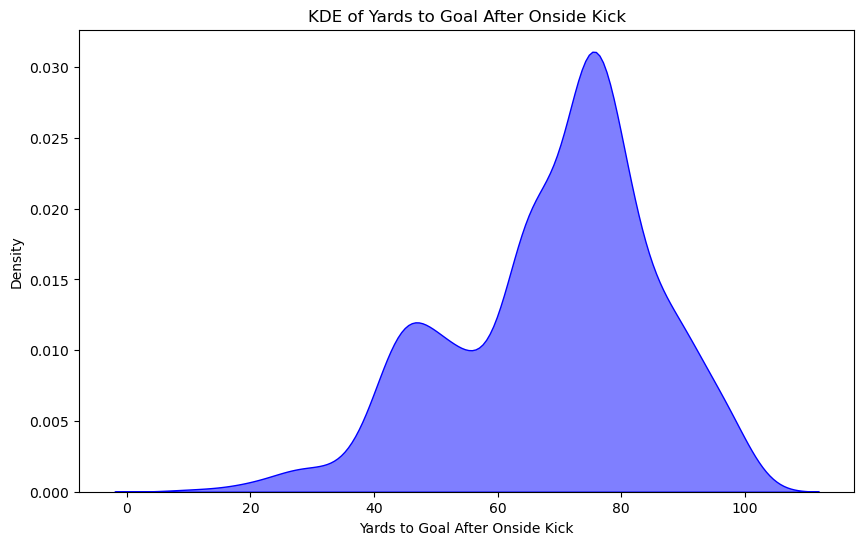

In [511]:
#plot yards_to_goal_after_onside_kick as kde
plt.figure(figsize=(10, 6))
sns.kdeplot(
    onside_kicks['yards_to_goal_after_onside_kick'].dropna(), 
    fill=True, 
    color='blue', 
    alpha=0.5
)
plt.title('KDE of Yards to Goal After Onside Kick')
plt.xlabel('Yards to Goal After Onside Kick')
plt.ylabel('Density')
plt.show()

In [515]:
onside_kicks.query('yards_to_goal_after_onside_kick==75').head()

,play_id,drive_id,game_id,drive_number,play_number,period,offense,defense,recovered_by,clock_minutes,clock_seconds,play_text,pct_game_played,yards_to_goal_after_onside_kick,prev_drive_number
171,400610205104989101,40061020526,400610205,26,1,4,Central Michigan,Western Kentucky,defense,1,8,Ron Coluzzi on-side kick recovered by WESTRN K...,0.981111,75.0,26.0
176,400610217103849901,40061021713,400610217,13,1,3,Missouri,Minnesota,offense,15,0,Andrew Baggett on-side kick recovered by MISSO...,0.500000,75.0,13.0
181,400610224104966903,40061022426,400610224,26,1,4,Iowa,Tennessee,defense,3,30,Marshall Koehn on-side kick recovered by TENNE...,0.941667,75.0,26.0
182,400548402103926603,40054840217,400548402,17,1,3,South Carolina,Texas A&M,defense,7,33,Landon Ard on-side kick recovered by TEXAS A&M...,0.624167,75.0,17.0
191,400610180104854603,40061018020,400610180,20,1,4,Mississippi State,Georgia Tech,defense,14,53,Devon Bell on-side kick recovered by GEORGIA T...,0.751944,75.0,20.0


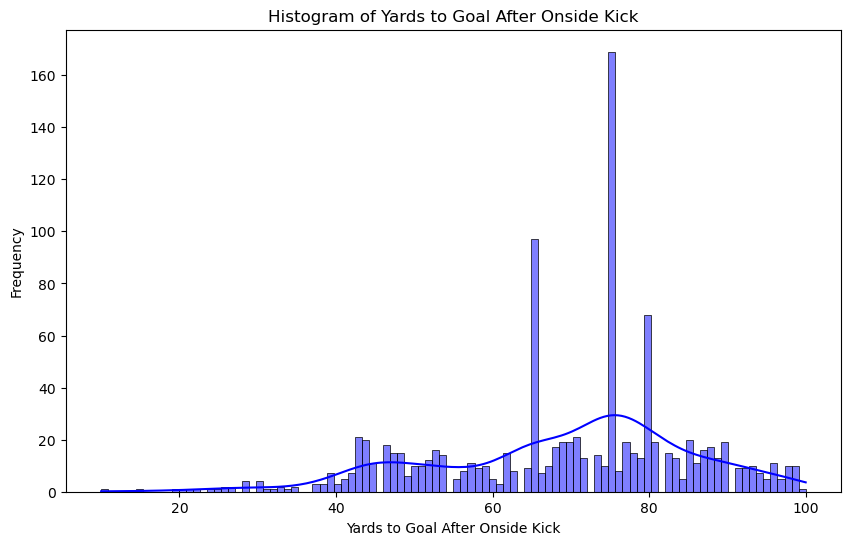

In [513]:
#plot yards_to_goal_after_onside_kick as histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    onside_kicks['yards_to_goal_after_onside_kick'].dropna(), 
    bins=100, 
    kde=True, 
    color='blue', 
    alpha=0.5
)
plt.title('Histogram of Yards to Goal After Onside Kick')
plt.xlabel('Yards to Goal After Onside Kick')
plt.ylabel('Frequency')
plt.show()